# Partial Correlations and Directed Acyclic Graphs

In [47]:
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin
import statsmodels.api as sm
from datlib.plots import *
import copy
import networkx as nx
plt.rcParams.update({"font.size": 32})

In [2]:
length = 10000
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0
sigma = 5

lst_dict = {col:[] for col in cols}

for i in range(length):
    lst_dict["P"].append(25 + np.random.normal(mu, 0.5 * sigma))
    lst_dict["Q"].append(50 + np.random.normal(mu, sigma))
    lst_dict["X"].append(3 * lst_dict["Q"][-1] + np.random.normal(mu, sigma))
    lst_dict["Y"].append(lst_dict["Q"][-1] * -1 + np.random.normal(mu,sigma))
    lst_dict["Z"].append(lst_dict["P"][-1] * 2 + 1.5 * lst_dict["X"][-1] - lst_dict["Y"][-1] * 2 + np.random.normal(mu, sigma))

df = pd.DataFrame(lst_dict)
keys = cols 
df

,P,Q,X,Y,Z
0,27.708990,51.398922,153.885905,-50.168707,389.072593
1,26.367778,51.090870,155.274725,-53.013797,393.253611
2,26.048823,48.627027,146.219727,-48.654500,374.217565
3,23.940989,56.572780,165.876560,-55.746101,410.350298
4,23.025311,49.911120,141.040060,-51.445422,353.239263
...,...,...,...,...,...
9995,23.932327,57.650385,178.577587,-63.469295,443.982802
9996,28.019112,47.227308,144.521142,-53.894439,380.064123
9997,20.285220,53.969197,168.150789,-55.466543,401.361921
9998,28.320592,52.637250,156.455573,-51.940587,387.761868


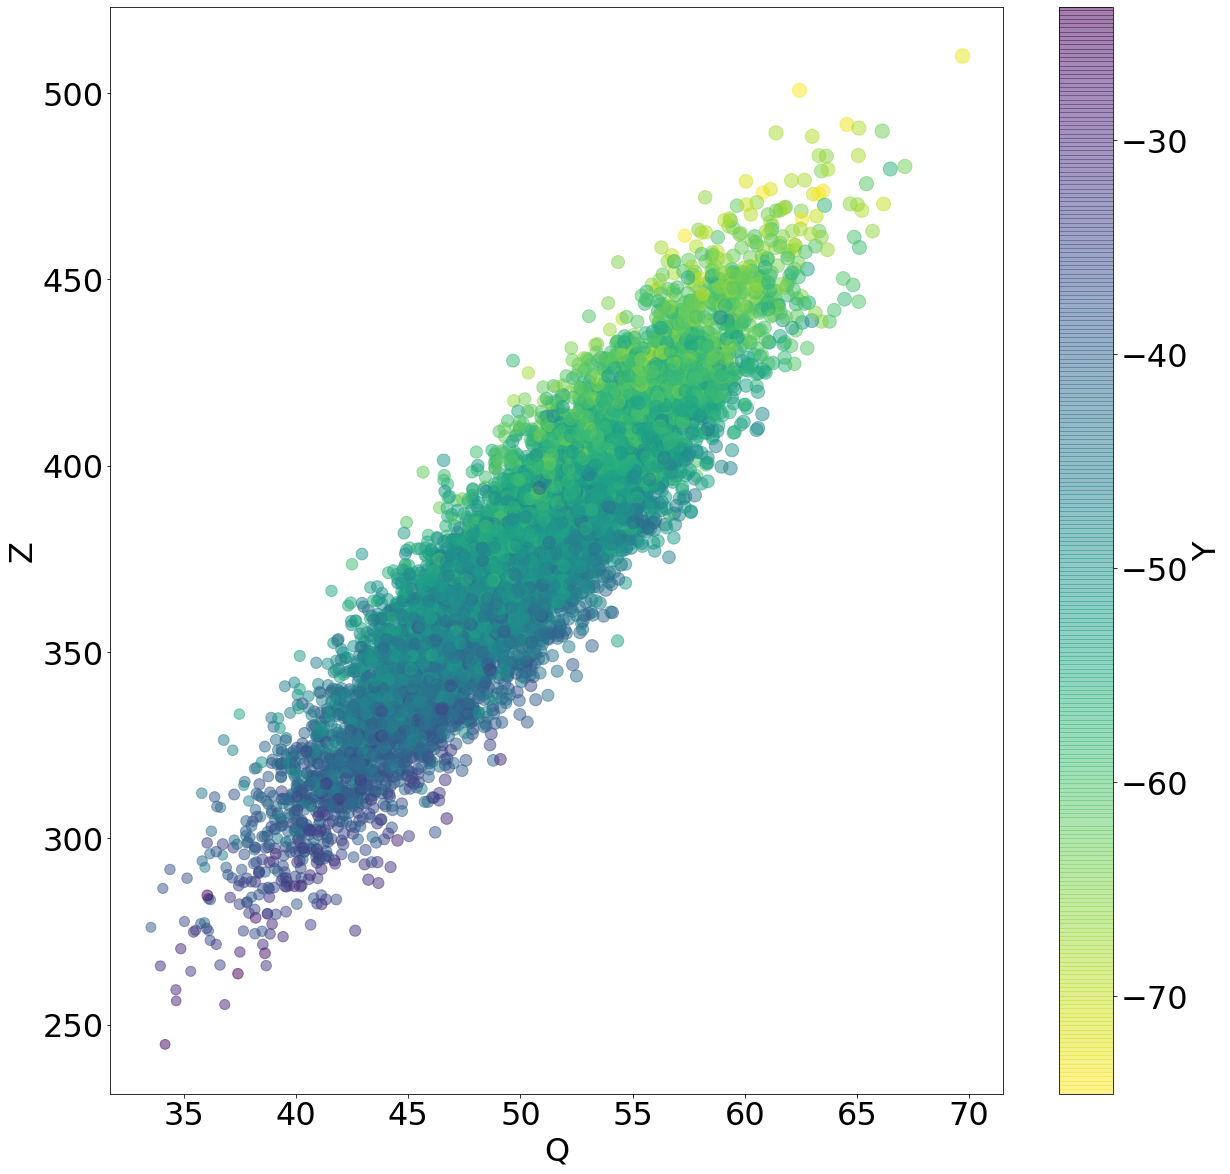

In [3]:
fig, ax = plt.subplots(figsize = (20,20))
df.plot.scatter(x = "Q", 
                y = "Z", 
                c = "Y", 
                s = "X", 
                cmap = "viridis_r", 
                alpha = 0.5, 
                ax = ax)
plt.show()
plt.close();

In [4]:
df.corr()

,P,Q,X,Y,Z
P,1.000000,-0.018793,-0.022008,0.002440,0.126696
Q,-0.018793,1.000000,0.948333,-0.701458,0.913259
X,-0.022008,0.948333,1.000000,-0.661590,0.931728
Y,0.002440,-0.701458,-0.661590,1.000000,-0.843159
Z,0.126696,0.913259,0.931728,-0.843159,1.000000


### Partial Correlation
Correlation of variables when controlling for other variables

In [18]:
residuals = {}
for y_var in df.keys():
    X_vars = list(df.keys())
    X_vars.remove(y_var)
    X = df[X_vars]
    X["Constant"] = 1
    y = df[y_var]
    model = sm.OLS(Y,X)
    results = model.fit()
    results.summary()
    residuals[y_var] = results.resid
residuals = pd.DataFrame(residuals)

In [19]:
residuals

,P,Q,X,Y,Z
0,-1.482280,0.006820,1.861879,2.528837,2.489007
1,-0.603774,-0.012230,0.139699,0.503568,1.560032
2,1.690191,-0.004000,3.631587,4.393346,5.465896
3,2.074254,0.034883,3.315661,2.080731,2.160086
4,-1.608033,0.044457,-0.953162,-6.356846,-7.229120
...,...,...,...,...,...
9995,1.609996,-0.027191,-1.739944,-1.335539,1.261510
9996,-3.231473,-0.032791,-1.761110,-3.045993,-0.541461
9997,3.363115,-0.029346,-4.539419,-2.657789,-2.470663
9998,-7.058469,0.013981,-4.487084,-5.615476,-7.427018


In [7]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.213e+05
Date:                Thu, 28 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:25:38   Log-Likelihood:                -30241.
No. Observations:               10000   AIC:                         6.049e+04
Df Residuals:                    9995   BIC:                         6.053e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
P              1.9915      0.020    100.179      0.000       1.953       2.030
Q             -0.0201      0.033     -0.600      0.549      -0.086       0.045
X              1.5076      0.010    150.120      0.000       1.488       1.527
Y             -1.9968      0.010   -200.823      0.000      -2.016      -1.977
Constant       0.2536      0.716      0.354      0.723      -1.150       1.657
==============================================================================
Omnibus:                        3.554   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.539
Skew:                          -0.034   Prob(JB):                        0.170
Kurtosis:                       2.938   Cond. No.                     2.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
residuals.corr()[residuals.corr().abs()<1].mul(-1).fillna(1).round(2)

,P,Q,X,Y,Z
P,1.00,0.01,-0.59,0.63,0.71
Q,0.01,1.00,0.51,-0.14,-0.01
X,-0.59,0.51,1.00,0.75,0.83
Y,0.63,-0.14,0.75,1.00,-0.90
Z,0.71,-0.01,0.83,-0.90,1.00


In [9]:
df.pcorr().round(2)

,P,Q,X,Y,Z
P,1.00,0.01,-0.59,0.63,0.71
Q,0.01,1.00,0.51,-0.14,-0.01
X,-0.59,0.51,1.00,0.75,0.83
Y,0.63,-0.14,0.75,1.00,-0.90
Z,0.71,-0.01,0.83,-0.90,1.00


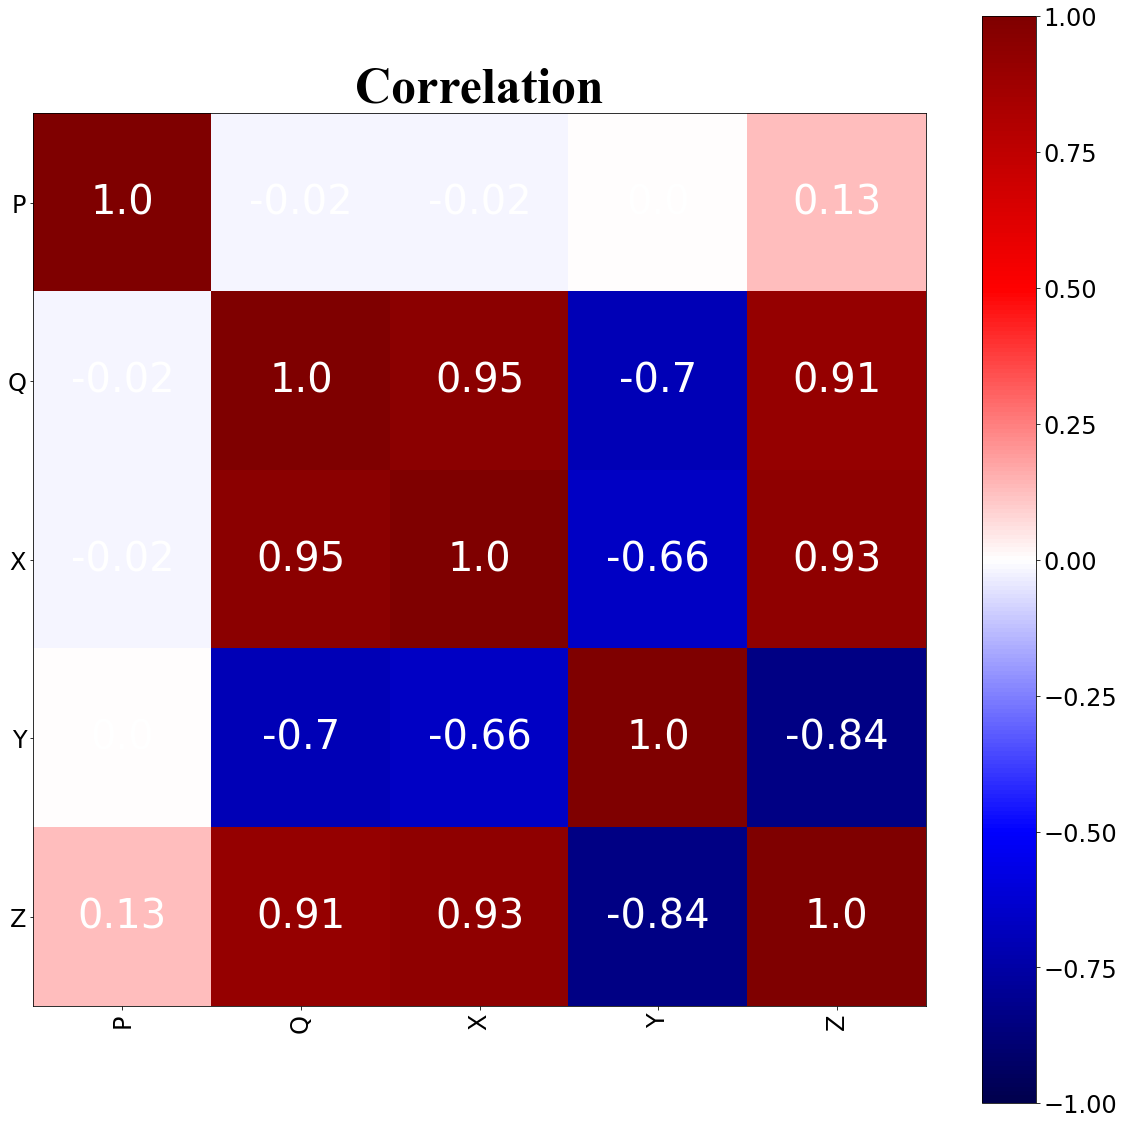

In [10]:
corr_matrix_heatmap(df.corr(), 
                    save_fig = False, 
                    pp = None,
                    title = "Correlation")

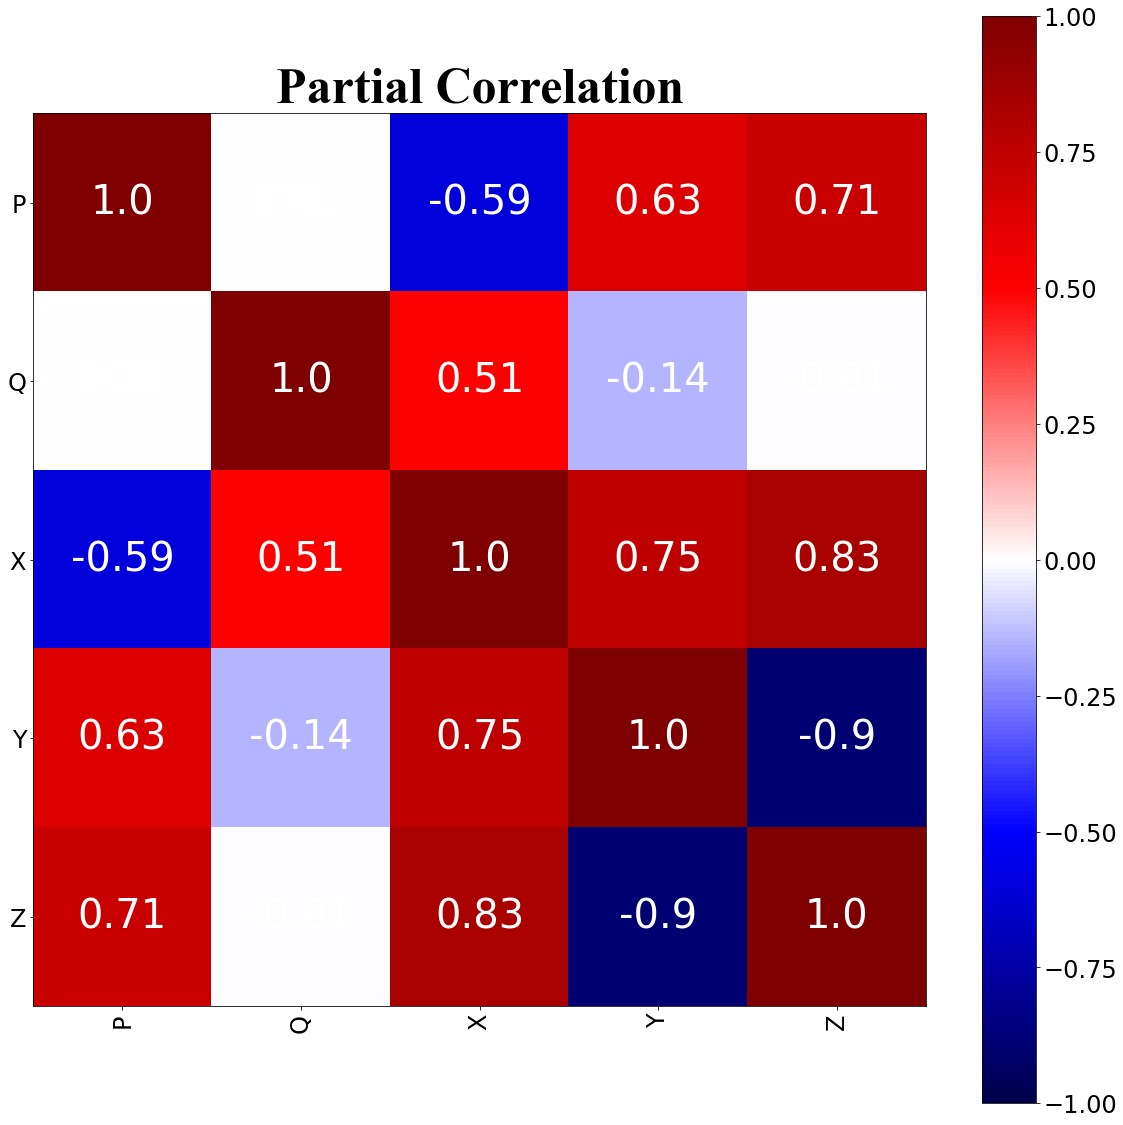

In [11]:
corr_matrix_heatmap(df.pcorr(), 
                    save_fig = False, 
                    pp = None,
                    title = "Partial Correlation")

In [44]:
pcorr_pvalues = {}

for y, Y in residuals.items():
    pcorr_pvalues[y] = {}
    for x, X in residuals.items():
        if x!=y:
            # regress 1 residual on the other
            # save the value for the expanatory variable
            # this is the pvalue of the partial correlation
            pcorr_pvalues[y][x] = sm.OLS(Y,X).fit().pvalues[x]
        else:
            pcorr_pvalues[y][x] = np.NaN
pcorr_values_df = pd.DataFrame(pcorr_pvalues).round(2)
pcorr_values_df

,P,Q,X,Y,Z
P,NaN,0.59,0.0,0.0,0.00
Q,0.59,NaN,0.0,0.0,0.55
X,0.00,0.00,NaN,0.0,0.00
Y,0.00,0.00,0.0,NaN,0.00
Z,0.00,0.55,0.0,0.0,NaN


In [45]:
undirected_graph = {key:[] for key in df.keys()}
for x in undirected_graph:
    undirected_graph[x]= [y for y in df.keys() if y != x]
undirected_graph

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

In [46]:
p_val = 0.01
def build_skeleton(df, undirected_graph):
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                # recursive function that iterates through remaining variables
                # uses them as controls statistical significance hold without them, 
                # otherwise break
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x!=y: 
                test = df.partial_corr(x=x, 
                                       y=y, 
                                       covar = None, 
                                       method = "pearson")
                if test["p-val"].values[0]>p_val:
                    undirected_graph[x].remove(y)
                else:
                    control_vars = [z for z in df.keys() if z!=y and z!=x]
                    check_remaining_controls(control_vars, 
                                             undirected_graph, 
                                             x, 
                                             y, 
                                             [])
    return undirected_graph

build_skeleton(df, undirected_graph)         

{'P': ['Z'],
 'Q': ['X', 'Y'],
 'X': ['Q', 'Z'],
 'Y': ['Q', 'Z'],
 'Z': ['P', 'X', 'Y']}

In [49]:
def graph_DAG(undirected_graph, df, title = "DAG Structure"):
    pcorr_matrix = df.pcorr()
    graph = nx.Graph
    edges = []
    edge_labels = {}
    for key in undirected_graph:
        for key2 in undirected_graph[key]:
            if (key2,key) not in edges:
                edge = (key.replace(" ", "\n"), key2[0].replace(" ", "\n"))
                edges.append(edge)
                edge_labels[edge] = str(round(pcorr_matrix.loc[key][key2],2))
    print(edges)
    print(edge_labels)
    graph.add_edges_from(edges)
graph_DAG(undirected_graph, df)

[('P', 'Z'), ('Q', 'X'), ('Q', 'Y'), ('X', 'Z'), ('Y', 'Z')]
{('P', 'Z'): '0.71', ('Q', 'X'): '0.51', ('Q', 'Y'): '-0.14', ('X', 'Z'): '0.83', ('Y', 'Z'): '-0.9'}


TypeError: add_edges_from() missing 1 required positional argument: 'ebunch_to_add'